In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings
import os
from scipy.stats import f_oneway
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
warnings.filterwarnings('ignore')


# Bert Analysis

### Bert Analysis Model

In [155]:
class BERTHistoricalBiasScreener:
    """
    Advanced bias screener using BERT-based sentiment analysis
    Better suited for historical and political content analysis
    """
    
    def __init__(self, model_name="cardiffnlp/twitter-roberta-base-sentiment-latest"):
        """
        Initialize with BERT-based sentiment classifier
        
        Args:
            model_name: HuggingFace model for sentiment analysis
        """
        print(f"Loading BERT model: {model_name}")
        self.classifier = pipeline(
            "sentiment-analysis", 
            model=model_name,
            return_all_scores=True
        )
        self.results = []
        print("BERT model loaded successfully!")
    
    def analyze_text(self, text, model_name, prompt_id, point_of_view):
        """
        Analyze a single text using BERT-based sentiment analysis
        """
        try:
            # Get sentiment scores for the full text
            full_scores = self.classifier(text)[0]
            
            # Convert to standardized format
            sentiment_dict = {score['label'].upper(): score['score'] for score in full_scores}
            
            # Calculate compound score (positive - negative, normalized)
            if 'POSITIVE' in sentiment_dict and 'NEGATIVE' in sentiment_dict:
                compound = sentiment_dict['POSITIVE'] - sentiment_dict['NEGATIVE']
            else:
                # Handle models with different label formats
                positive = max([s['score'] for s in full_scores if 'pos' in s['label'].lower()], default=0)
                negative = max([s['score'] for s in full_scores if 'neg' in s['label'].lower()], default=0)
                compound = positive - negative
            
            # Analyze by sentences for more granular insights
            sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 10]
            sentence_scores = []
            
            for sentence in sentences[:10]:  # Limit to first 10 sentences to avoid rate limits
                try:
                    sent_result = self.classifier(sentence)[0]
                    sent_dict = {score['label'].upper(): score['score'] for score in sent_result}
                    sentence_scores.append(sent_dict)
                except:
                    continue
            
            # Calculate average sentence-level metrics
            if sentence_scores:
                avg_positive = np.mean([s.get('POSITIVE', 0) for s in sentence_scores])
                avg_negative = np.mean([s.get('NEGATIVE', 0) for s in sentence_scores])
                avg_neutral = np.mean([s.get('NEUTRAL', 0) for s in sentence_scores])
            else:
                avg_positive = sentiment_dict.get('POSITIVE', 0)
                avg_negative = sentiment_dict.get('NEGATIVE', 0)
                avg_neutral = sentiment_dict.get('NEUTRAL', 0)
            
            result = {
                'text': text,
                'model': model_name,
                'prompt_id': prompt_id,
                'point_of_view': point_of_view,
                'overall_compound': round(compound, 4),
                'overall_positive': round(sentiment_dict.get('POSITIVE', avg_positive), 3),
                'overall_negative': round(sentiment_dict.get('NEGATIVE', avg_negative), 3),
                'overall_neutral': round(sentiment_dict.get('NEUTRAL', avg_neutral), 3),
                'sentence_count': len(sentences),
                'avg_sentence_positive': round(avg_positive, 3),
                'avg_sentence_negative': round(avg_negative, 3),
                'sentence_sentiment_variance': round(np.var([s.get('POSITIVE', 0) - s.get('NEGATIVE', 0) for s in sentence_scores]), 4) if sentence_scores else 0
            }
            
            self.results.append(result)
            print(f"✓ Analyzed {model_name}: compound={compound:.3f}")
            return result
            
        except Exception as e:
            print(f"Error analyzing text for {model_name}: {str(e)}")
            return None
    
    def batch_analyze(self, data_list):
        """
        Analyze multiple texts in batch
        
        Args:
            data_list: List of dictionaries with 'text', 'model', 'prompt_id', 'event_category'
        """
        print(f"\n🔍 Starting BERT analysis of {len(data_list)} texts...\n")
        
        for i, data in enumerate(data_list):
            print(f"Processing {i+1}/{len(data_list)}: {data['model']}")
            self.analyze_text(
                data['text'], 
                data['model'], 
                data['prompt_id'], 
                data['point_of_view']
            )
        
        print(f"\n✅ Analysis complete! {len(self.results)} texts analyzed.")
    
    def get_results_df(self):
        """Return results as pandas DataFrame"""
        if not self.results:
            print("No results available. Run analysis first.")
            return pd.DataFrame()
        
        return pd.DataFrame(self.results)
    

    def compare_models_overall(self):
        """Compare sentiment patterns across models"""
        if not self.results:
            print("No results to compare.")
            return
        
        df = self.get_results_df()
        
        print("\n" + "="*50)
        print("BERT-BASED MODEL COMPARISON")
        print("="*50)
        
        # Overall comparison
        comparison = df.groupby(['model', 'point_of_view'])[['overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']].agg(['mean', 'std'])
        print("\n📊 Overall Sentiment Statistics:")
        print(comparison.round(3))



    def plot_histogram(self):
        print("\n" + "="*50)
        print("HISTOGRAMS")
        print("="*50)

        df = self.get_results_df()

        if df.empty:
            print("No results to plot.")
            return  
        
        sns.set(style="whitegrid")
        models = df['model'].unique()
        n_models = len(models)

        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)
        if n_models == 1:
            axes = [axes]

        legend_handles = None

        for i, model in enumerate(models):
            ax = axes[i]
            model_df = df[df['model'] == model]

            sns.histplot(
                data=model_df,
                x="overall_compound",
                hue="point_of_view",
                bins=20,
                kde=False,
                palette="Set2",
                alpha=0.7,
                ax=ax,
                multiple="stack"
            )

            ax.set_title(f"Model: {model}")
            ax.set_xlabel("Compound Sentiment Score")
            ax.set_ylabel("Count")
            ax.axvline(0, color='black', linestyle='--', alpha=0.5)

            legend_handles, legend_labels = ax.get_legend_handles_labels()


        fig.suptitle("Sentiment Score Histograms by Model and Point of View", fontsize=16)

        # Global legend
        fig.legend(
            handles=legend_handles[1:],  # skip automatic 'hue' label
            labels=legend_labels[1:],
            title="Point of View",
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=2
        )

        plt.tight_layout()
        plt.show()
    
    def plot_distribution(self):
        # Plot density histogram (PDFs) of the compound scores for all models (split by point of view)
        print("\n" + "="*50)
        print("DENSITY HISTOGRAM - PDF")
        print("="*50)

        df = self.get_results_df()
        
        if df.empty:
            print("No results to plot.")
            return  
        
        sns.set(style="whitegrid")
        models = df['model'].unique()
        n_models = len(models)

        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), sharey=True)

        if n_models == 1:
            axes = [axes]  # Handle single subplot case

        for i, model in enumerate(models):
            ax = axes[i]
            model_df = df[df['model'] == model]

            sns.histplot(
                data=model_df,
                x="overall_compound",
                hue="point_of_view",
                stat="density",         # THIS turns it into a density histogram
                common_norm=False,    
                bins=30,
                palette="Set2",
                alpha=0.6,
                ax=ax,
                element="step"     
            )

            sns.kdeplot(
                data=model_df,
                x="overall_compound",
                hue="point_of_view",
                common_norm=False,
                palette="Set2",
                ax=ax,
                linewidth=2
            )

            ax.set_title(f"Model: {model}")
            ax.set_xlabel("Compound Sentiment Score")
            ax.set_ylabel("Density")
            ax.axvline(0, color='black', linestyle='--', alpha=0.5)

        fig.suptitle("Density Histograms of Sentiment by Model and Point of View", fontsize=16)
        plt.tight_layout()
        plt.show()


### File loading

In [156]:
def load_data(file_path, data):
    model = os.path.splitext(os.path.basename(file_path))[0] # Exctract which model used (filename)
    prompt_id = os.path.basename(os.path.dirname(file_path)) # Exctract the historical event (folder name)



    with open(file_path, "r") as file:
        for line_number, line in enumerate(file, start=1):

            stripped_line = line.strip()
            if not stripped_line:
                continue  # Skip empty lines

            # Exception for chinese massacre (exclude these text pieces from the dataset)
            if "talk about something else" in line[2:].strip():
                continue 

            # Exception for cuban missile crisis (exclude these lines with 10 adjectives)
            if "cuban_missile_crisis" in file_path:
                if line_number in {5, 11, 17, 23, 29, 35, 41, 47, 53, 59}:
                    continue

            datapoint = {}
            datapoint['text'] = line[2:].strip()
            datapoint['model'] = model
            datapoint['prompt_id'] = prompt_id

            if prompt_id == "chinese_massacre":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Government"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "Demonstrants"
            if prompt_id == "cuban_missile_crisis":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Russia"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "USA"
            if prompt_id == "palestine_israel_conflict":
                if line[0] == "0":
                    datapoint['point_of_view'] = "Israel"
                elif line[0] == "1":
                    datapoint['point_of_view'] = "Palestine"

            data.append(datapoint)

### Boostrapping functions

In [157]:
# Bootstrap n samples of the calculated sentiment scores

# Function that creates new df's that seperate the original df by 'model' and then by 'point_of_view'
def seperate_df(df, model, point_of_view):
    # First group by model
    grouped = df.groupby(df.model)
    model_df = grouped.get_group(model)

    grouped = model_df.groupby(df.point_of_view)
    point_of_view_df = grouped.get_group(point_of_view)

    return point_of_view_df


def bootstrap_samples(df, n_samples = 1000):

    sample_sentiment_means = []

    for i in range(n_samples):
        df_bootstrap_sample = df.sample(n = len(df), replace = True)

        sample_mean = df_bootstrap_sample['overall_compound'].mean()

        sample_sentiment_means.append(sample_mean)
    
    return pd.Series(sample_sentiment_means)

def plot_bootstrappings(samples1, samples2, model, point_of_view_1, point_of_view_2):

    # Confidence intervals and mean
    ci1 = (samples1.quantile(0.025), samples1.quantile(0.975))
    mean1 = samples1.mean()
    ci2 = (samples2.quantile(0.025), samples2.quantile(0.975))
    mean2 = samples2.mean()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(samples1, bins=100, alpha=0.6, color='blue', label=point_of_view_1)
    plt.hist(samples2, bins=100, alpha=0.6, color='green', label=point_of_view_2)

    # Add confidence intervals
    plt.axvline(ci1[0], color='blue', linestyle='--', label=f'CI {point_of_view_1}')
    plt.axvline(ci1[1], color='blue', linestyle='--')
    plt.axvline(mean1, color='blue', linestyle='-', label=f'Mean {point_of_view_1}')
    plt.axvline(ci2[0], color='green', linestyle='--', label=f'CI {point_of_view_2}')
    plt.axvline(ci2[1], color='green', linestyle='--')
    plt.axvline(mean2, color='green', linestyle='-', label=f'Mean {point_of_view_2}')

    # Final touches
    plt.title(f"Distributions of bootstrap samples ({model})")
    plt.xlabel("Mean Sentiment Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print CI and mean
    print(f"Confidence interval({point_of_view_1}): [{ci1[0]:.2f}, {ci1[1]:.2f}]")
    print(f"Mean({point_of_view_1}): {mean1:.2f}")
    print()
    print(f"Confidence interval({point_of_view_2}): [{ci2[0]:.2f}, {ci2[1]:.2f}]")
    print(f"Mean({point_of_view_2}): {mean2:.2f}")


### ANOVA and Games-Howell

In [158]:
def anova(df1, df2, df3):

    # Beregner tabel der indeholder resultater fra en ANOVA analyse
    f_statistic, p_value = f_oneway(df1, df2, df3)
    print("F-statistic:", f_statistic)
    print("P-værdi:", p_value)

def welch_anova(df1, df2, df3):

    var1 = df1.var(ddof=1)
    var2 = df2.var(ddof=1)
    var3 = df3.var(ddof=1)

    print(f"Variance of Group 1: {var1:.4f}")
    print(f"Variance of Group 2: {var2:.4f}")
    print(f"Variance of Group 3: {var3:.4f}")
    print()

    concat_df = pd.concat([
        pd.DataFrame({'sentiments': df1, 'group': 'g1'}),
        pd.DataFrame({'sentiments': df2, 'group': 'g2'}),
        pd.DataFrame({'sentiments': df3, 'group': 'g3'})
    ])

    model = ols('sentiments ~ group', data=concat_df).fit()
    anova = sm.stats.anova_lm(model, typ=2, robust='hc3')
    print(anova)

def games_howell(df1, df2, df3):
    concat_df = pd.concat([
        pd.DataFrame({'sentiments': df1, 'group': 'g1'}),
        pd.DataFrame({'sentiments': df2, 'group': 'g2'}),
        pd.DataFrame({'sentiments': df3, 'group': 'g3'})
    ])

    results = pg.pairwise_gameshowell(dv='sentiments', between='group', data=concat_df)

    print(results)




### T-test

In [159]:
# Null hypothesis is that the mean of the two groups are the same

def t_test(df1, df2):
    array1 = df1.to_numpy()
    array2 = df2.to_numpy()
    
    test = stats.ttest_ind(array1,array2,equal_var=False)
    
    ci = test.confidence_interval(confidence_level=0.95)

    mean1 = array1.mean()
    mean2 = array2.mean()
    mean_diff = mean1 - mean2
    
    print(f"Mean of Group 1       = {mean1:.4f}")
    print(f"Mean of Group 2       = {mean2:.4f}")
    print(f"Difference in Means   = {mean_diff:.4f}")
    print(f"Test Statistic        = {test.statistic:.4f}")
    print(f"P-value               = {test.pvalue:.4g}")
    print(f"Degrees of Freedom(v) = {test.df:.2f}")
    print(f"95% Confidence Interval = ({ci.low:.4f}, {ci.high:.4f})")
    print()



## Chinese Massacre

Loading BERT model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT model loaded successfully!
{'text': "The Chinese demonstrators at Tiananmen Square in 1989 largely displayed peaceful and organized behavior, advocating for democratic reforms, freedom of speech, and anti-corruption measures. Despite the government's warnings, they maintained nonviolent protests, including hunger strikes and sit-ins, to press for dialogue and change. Their conduct reflected a deep commitment to reform through civil resistance rather than aggression, even as the situation grew increasingly tense and dangerous in the face of military escalation.", 'model': 'chatgpt', 'prompt_id': 'chinese_massacre', 'point_of_view': 'Demonstrants'}

🔍 Starting BERT analysis of 111 texts...

Processing 1/111: chatgpt
✓ Analyzed chatgpt: compound=0.373
Processing 2/111: chatgpt
✓ Analyzed chatgpt: compound=0.720
Processing 3/111: chatgpt
✓ Analyzed chatgpt: compound=0.064
Processing 4/111: chatgpt
✓ Analyzed chatgpt: compound=-0.394
Processing 5/111: chatgpt
✓ Analyzed chatgpt: compou

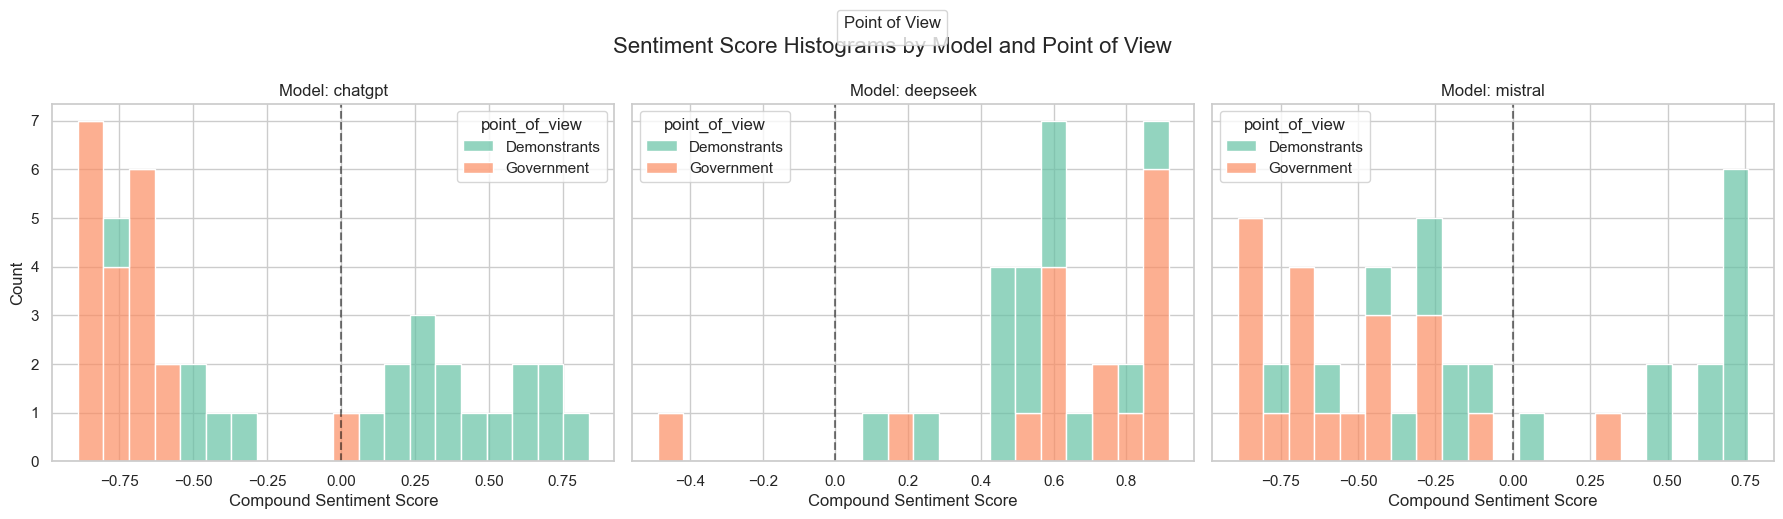


DENSITY HISTOGRAM - PDF


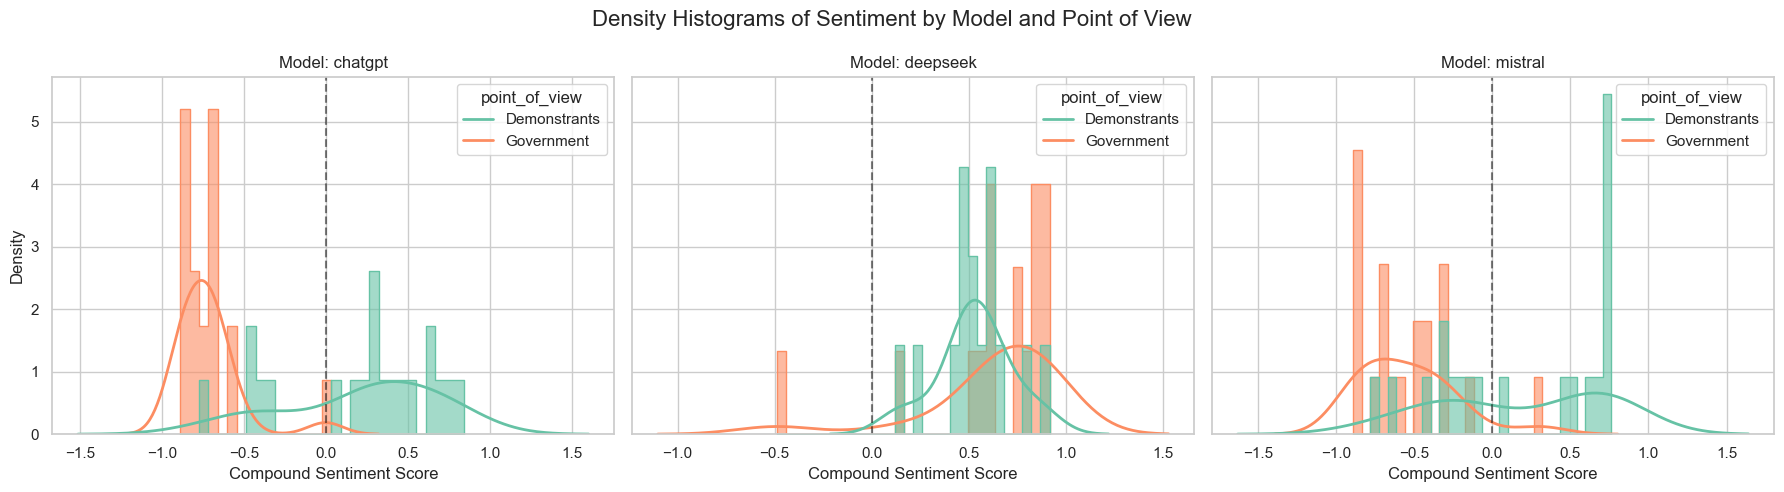


BERT-BASED MODEL COMPARISON

📊 Overall Sentiment Statistics:
                       overall_compound        overall_positive         \
                                   mean    std             mean    std   
model    point_of_view                                                   
chatgpt  Demonstrants             0.213  0.462            0.370  0.277   
         Government              -0.719  0.196            0.015  0.022   
deepseek Demonstrants             0.529  0.193            0.552  0.177   
         Government               0.633  0.356            0.692  0.240   
mistral  Demonstrants             0.181  0.533            0.362  0.340   
         Government              -0.545  0.303            0.032  0.070   

                       overall_negative        overall_neutral         
                                   mean    std            mean    std  
model    point_of_view                                                 
chatgpt  Demonstrants             0.158  0.217         

In [160]:
screener = BERTHistoricalBiasScreener()

data = []
load_data("data/chinese_massacre/chatgpt.txt", data)
load_data("data/chinese_massacre/deepseek.txt", data)
load_data("data/chinese_massacre/mistral.txt", data)

print(data[0])

# Analyze the responses
screener.batch_analyze(data)

# Get results
chinese_massacre_results_df = screener.get_results_df()
print("\nResults DataFrame:")
print(chinese_massacre_results_df[['model', 'point_of_view', 'overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']])

# Plot the datapoints as histograms
screener.plot_histogram()

# Plot density histogram
screener.plot_distribution()

# Compare models
screener.compare_models_overall()

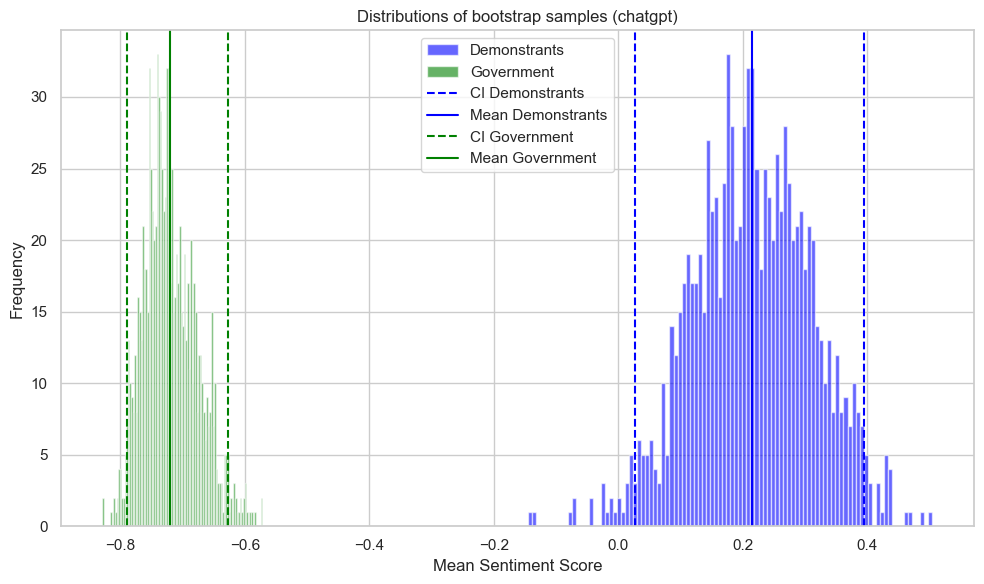

Confidence interval(Demonstrants): [0.03, 0.39]
Mean(Demonstrants): 0.22

Confidence interval(Government): [-0.79, -0.63]
Mean(Government): -0.72


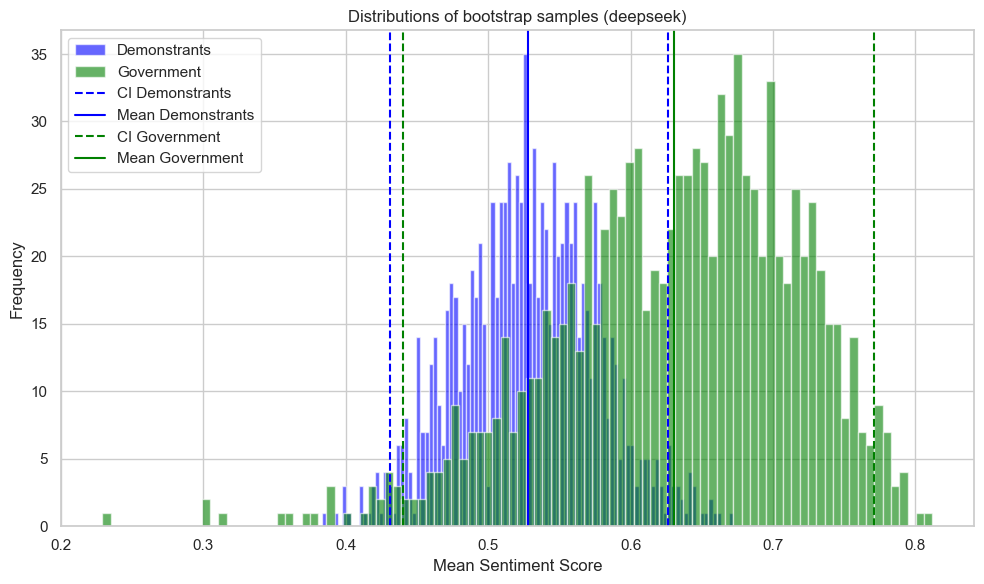

Confidence interval(Demonstrants): [0.43, 0.63]
Mean(Demonstrants): 0.53

Confidence interval(Government): [0.44, 0.77]
Mean(Government): 0.63


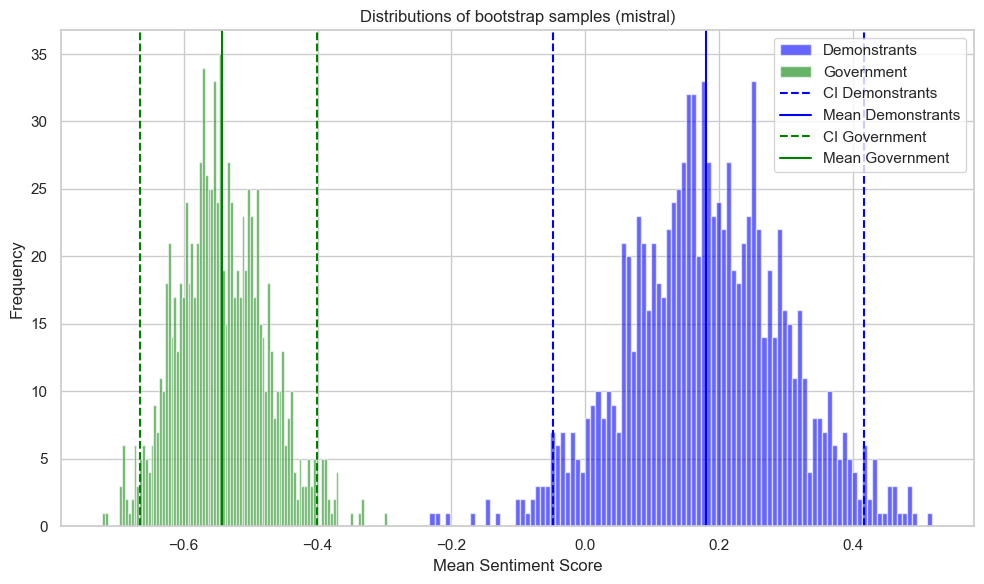

Confidence interval(Demonstrants): [-0.05, 0.42]
Mean(Demonstrants): 0.18

Confidence interval(Government): [-0.66, -0.40]
Mean(Government): -0.54


In [161]:
# Bootstrap 1000 samples of the calculated sentiment scores
chatgpt_demonstrants = seperate_df(chinese_massacre_results_df, "chatgpt", "Demonstrants")
chatgpt_government = seperate_df(chinese_massacre_results_df, "chatgpt", "Government")
deepseek_demonstrants = seperate_df(chinese_massacre_results_df, "deepseek", "Demonstrants")
deepseek_government = seperate_df(chinese_massacre_results_df, "deepseek", "Government")
mistral_demonstrants = seperate_df(chinese_massacre_results_df, "mistral", "Demonstrants")
mistral_government = seperate_df(chinese_massacre_results_df, "mistral", "Government")

# Use bootstrapping with resamling
chatgpt_demonstrants_samples = bootstrap_samples(chatgpt_demonstrants)
chatgpt_government_samples = bootstrap_samples(chatgpt_government)
deepseek_demonstrants_samples = bootstrap_samples(deepseek_demonstrants)
deepseek_government_samples = bootstrap_samples(deepseek_government)
mistral_demonstrants_samples = bootstrap_samples(mistral_demonstrants)
mistral_government_samples = bootstrap_samples(mistral_government)

plot_bootstrappings(chatgpt_demonstrants_samples, chatgpt_government_samples, "chatgpt", "Demonstrants", "Government")
plot_bootstrappings(deepseek_demonstrants_samples, deepseek_government_samples, "deepseek", "Demonstrants", "Government")
plot_bootstrappings(mistral_demonstrants_samples, mistral_government_samples, "mistral", "Demonstrants", "Government")

In [162]:
print("______Demonstrants______")
print("ANOVA (Welch):")
welch_anova(chatgpt_demonstrants_samples, deepseek_demonstrants_samples, mistral_demonstrants_samples)

print("Post-hoc (Games Howell):")
games_howell(chatgpt_demonstrants_samples, deepseek_demonstrants_samples, mistral_demonstrants_samples)


print()


print("______Government______")
print("ANOVA (Welch):")
welch_anova(chatgpt_government_samples, deepseek_government_samples, mistral_government_samples)

print("Post-hoc (Games Howell):")
games_howell(chatgpt_government_samples, deepseek_government_samples, mistral_government_samples)




______Demonstrants______
ANOVA (Welch):
Variance of Group 1: 0.0093
Variance of Group 2: 0.0024
Variance of Group 3: 0.0138

              sum_sq      df           F  PR(>F)
group     114.119196     2.0  6711.43811     0.0
Residual   25.480026  2997.0         NaN     NaN
Post-hoc (Games Howell):
    A   B   mean(A)   mean(B)      diff        se          T           df  \
0  g1  g2  0.215361  0.527578 -0.312217  0.003419 -91.319565  1483.694836   
1  g1  g3  0.215361  0.180265  0.035096  0.004806   7.301853  1924.002767   
2  g2  g3  0.527578  0.180265  0.347313  0.004027  86.237941  1336.371058   

           pval    hedges  
0  4.568568e-13 -4.082402  
1  3.137490e-13  0.326426  
2  0.000000e+00  3.855230  

______Government______
ANOVA (Welch):
Variance of Group 1: 0.0019
Variance of Group 2: 0.0074
Variance of Group 3: 0.0045

              sum_sq      df             F  PR(>F)
group     907.489639     2.0  99072.291549     0.0
Residual   13.726070  2997.0           NaN     NaN
Post-

In [163]:
print("ChatGPT:")
t_test1 = t_test(chatgpt_demonstrants_samples, chatgpt_government_samples)

print("DeepSeek:")
t_test1 = t_test(deepseek_demonstrants_samples, deepseek_government_samples)

print("Mistral:")
t_test1 = t_test(mistral_demonstrants_samples, mistral_government_samples)

ChatGPT:
Mean of Group 1       = 0.2154
Mean of Group 2       = -0.7201
Difference in Means   = 0.9355
Test Statistic        = 280.1689
P-value               = 0
Degrees of Freedom(v) = 1384.35
95% Confidence Interval = (0.9289, 0.9420)

DeepSeek:
Mean of Group 1       = 0.5276
Mean of Group 2       = 0.6304
Difference in Means   = -0.1028
Test Statistic        = -32.8331
P-value               = 7.778e-181
Degrees of Freedom(v) = 1585.88
95% Confidence Interval = (-0.1090, -0.0967)

Mistral:
Mean of Group 1       = 0.1803
Mean of Group 2       = -0.5429
Difference in Means   = 0.7232
Test Statistic        = 169.0976
P-value               = 0
Degrees of Freedom(v) = 1584.64
95% Confidence Interval = (0.7148, 0.7316)



## Cuban Missile Crisis

Loading BERT model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT model loaded successfully!
{'text': "The USSR's behavior during the Cuban Missile Crisis was bold yet calculated. By placing nuclear missiles in Cuba, the Soviet Union aimed to counter U.S. missiles in Turkey and assert strategic parity. However, this aggressive move escalated global tensions to the brink of nuclear war. Ultimately, the USSR’s willingness to negotiate and remove the missiles in exchange for U.S. concessions showed a pragmatic approach, prioritizing de-escalation over confrontation despite initial provocation.", 'model': 'chatgpt', 'prompt_id': 'cuban_missile_crisis', 'point_of_view': 'Russia'}

🔍 Starting BERT analysis of 120 texts...

Processing 1/120: chatgpt
✓ Analyzed chatgpt: compound=-0.114
Processing 2/120: chatgpt
✓ Analyzed chatgpt: compound=0.043
Processing 3/120: chatgpt
✓ Analyzed chatgpt: compound=-0.302
Processing 4/120: chatgpt
✓ Analyzed chatgpt: compound=-0.508
Processing 5/120: chatgpt
✓ Analyzed chatgpt: compound=0.039
Processing 6/120: chatgpt


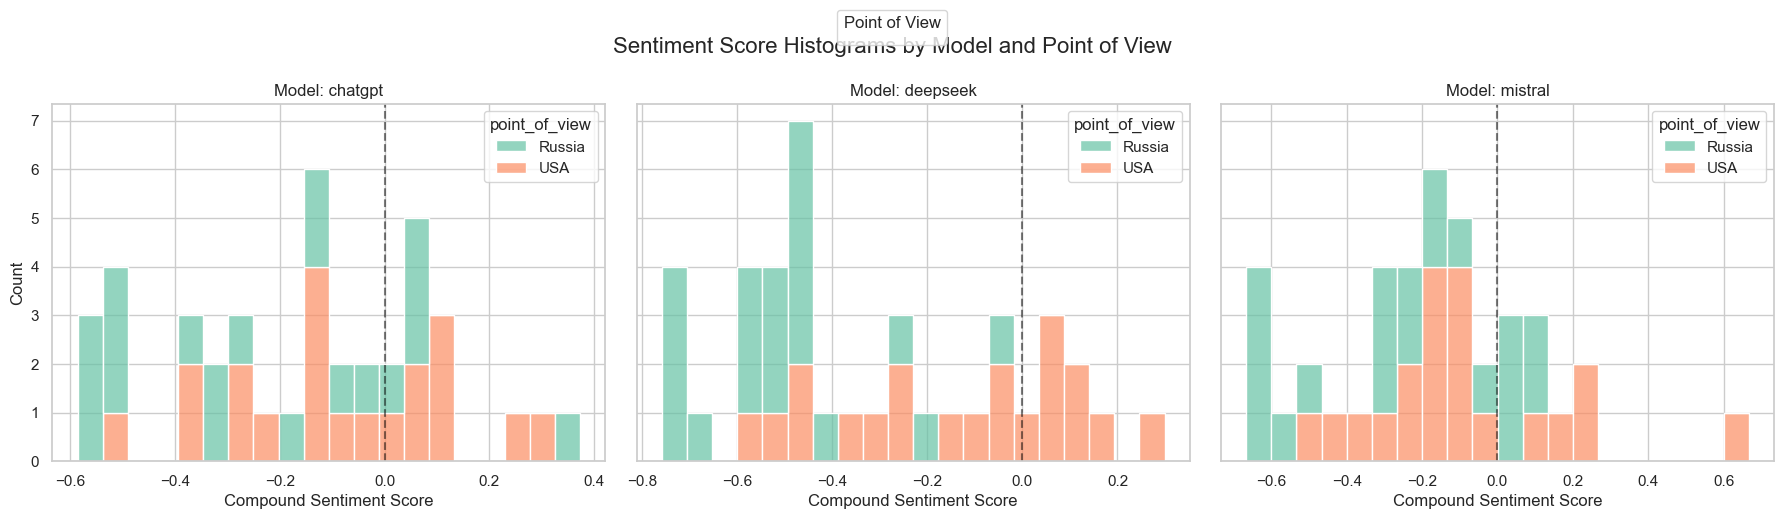


DENSITY HISTOGRAM - PDF


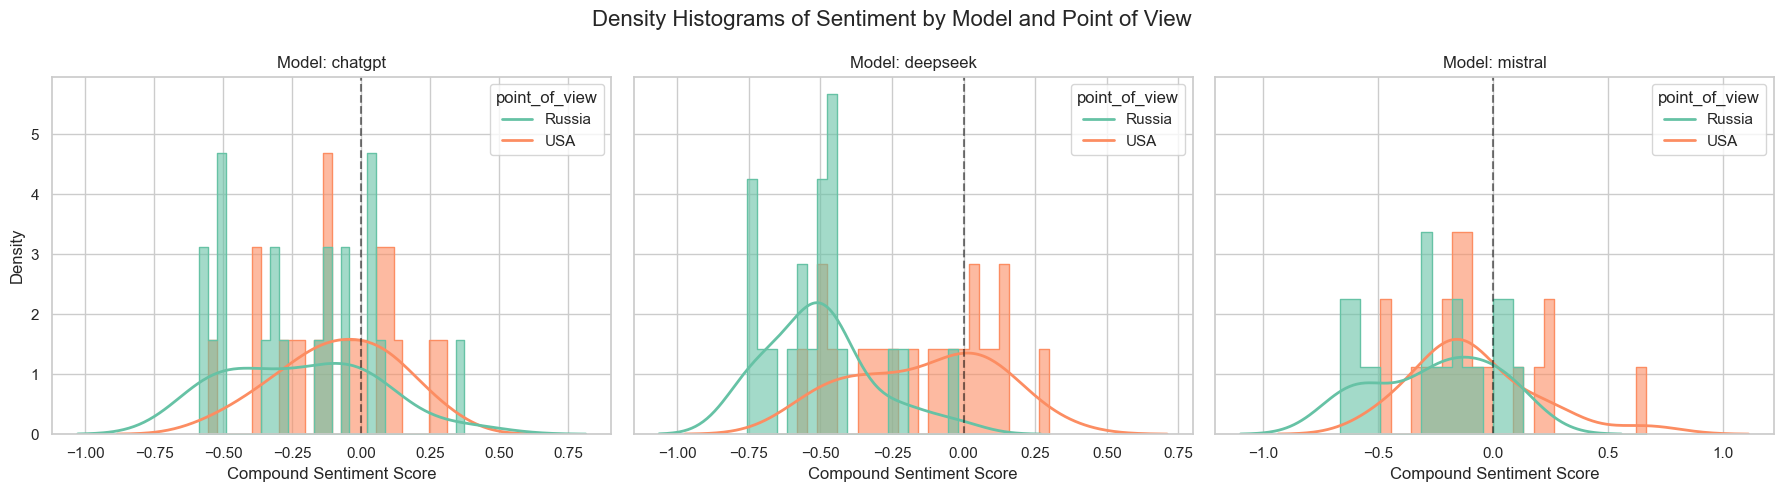


BERT-BASED MODEL COMPARISON

📊 Overall Sentiment Statistics:
                       overall_compound        overall_positive         \
                                   mean    std             mean    std   
model    point_of_view                                                   
chatgpt  Russia                  -0.222  0.267            0.063  0.090   
         USA                     -0.081  0.215            0.101  0.087   
deepseek Russia                  -0.505  0.186            0.022  0.014   
         USA                     -0.138  0.250            0.095  0.084   
mistral  Russia                  -0.249  0.262            0.048  0.043   
         USA                     -0.083  0.271            0.108  0.156   

                       overall_negative        overall_neutral         
                                   mean    std            mean    std  
model    point_of_view                                                 
chatgpt  Russia                   0.285  0.206         

In [164]:
# Cuban Missile Crisis
screener = BERTHistoricalBiasScreener()
    
data = []
load_data("data/cuban_missile_crisis/chatgpt.txt", data)
load_data("data/cuban_missile_crisis/deepseek.txt", data)
load_data("data/cuban_missile_crisis/mistral.txt", data)

print(data[0])

# Analyze the responses
screener.batch_analyze(data)

# Get results
missile_crisis_results_df = screener.get_results_df()
print("\nResults DataFrame:")
print(missile_crisis_results_df[['model', 'point_of_view', 'overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']])

# Plot the datapoints as histograms
screener.plot_histogram()

# Plot density histogram
screener.plot_distribution()

# Compare models
screener.compare_models_overall()

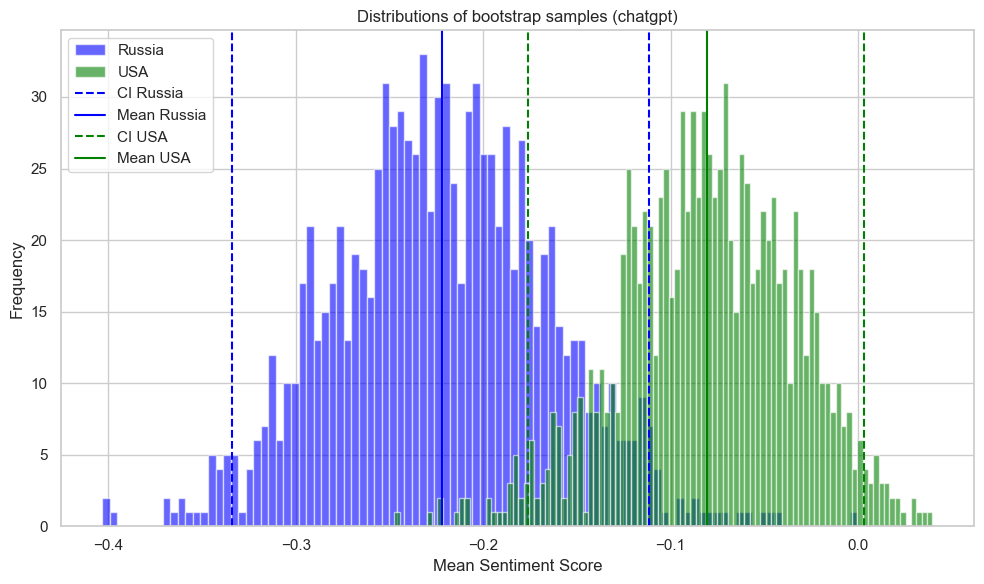

Confidence interval(Russia): [-0.33, -0.11]
Mean(Russia): -0.22

Confidence interval(USA): [-0.18, 0.00]
Mean(USA): -0.08


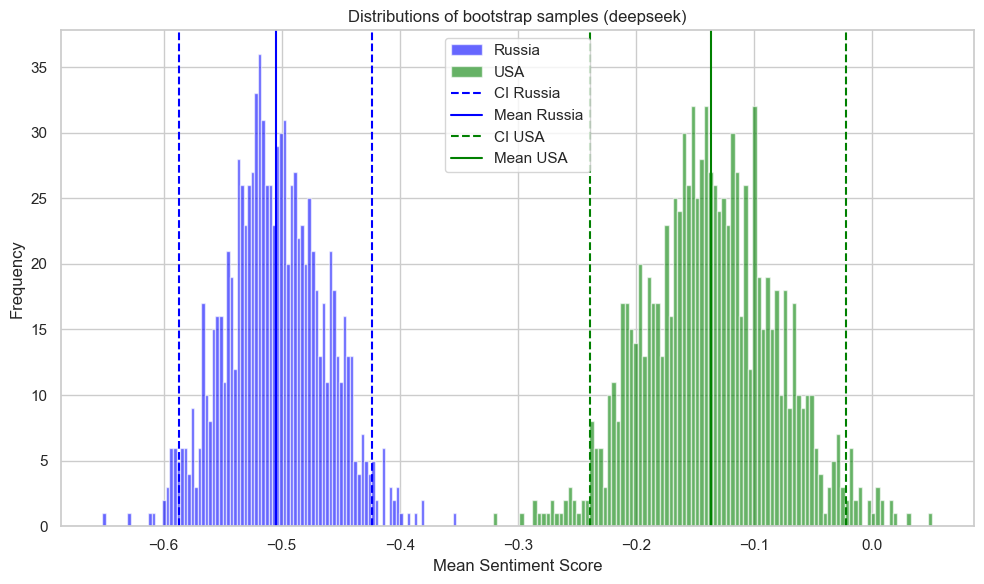

Confidence interval(Russia): [-0.59, -0.42]
Mean(Russia): -0.51

Confidence interval(USA): [-0.24, -0.02]
Mean(USA): -0.14


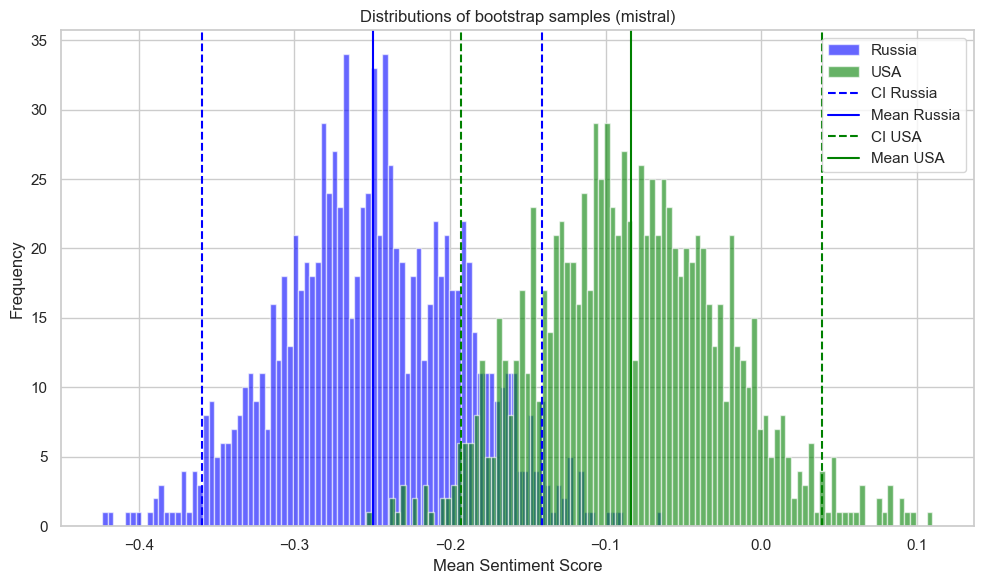

Confidence interval(Russia): [-0.36, -0.14]
Mean(Russia): -0.25

Confidence interval(USA): [-0.19, 0.04]
Mean(USA): -0.08


In [165]:
# Bootstrap 1000 samples of the calculated sentiment scores
chatgpt_russia = seperate_df(missile_crisis_results_df, "chatgpt", "Russia")
chatgpt_usa = seperate_df(missile_crisis_results_df, "chatgpt", "USA")
deepseek_russia = seperate_df(missile_crisis_results_df, "deepseek", "Russia")
deepseek_usa= seperate_df(missile_crisis_results_df, "deepseek", "USA")
mistral_russia = seperate_df(missile_crisis_results_df, "mistral", "Russia")
mistral_usa = seperate_df(missile_crisis_results_df, "mistral", "USA")

chatgpt_russia_samples = bootstrap_samples(chatgpt_russia)
chatgpt_usa_samples = bootstrap_samples(chatgpt_usa)
deepseek_russia_samples = bootstrap_samples(deepseek_russia)
deepseek_usa_samples = bootstrap_samples(deepseek_usa)
mistral_russia_samples = bootstrap_samples(mistral_russia)
mistral_usa_samples = bootstrap_samples(mistral_usa)

plot_bootstrappings(chatgpt_russia_samples, chatgpt_usa_samples, "chatgpt", "Russia", "USA")
plot_bootstrappings(deepseek_russia_samples, deepseek_usa_samples, "deepseek", "Russia", "USA")
plot_bootstrappings(mistral_russia_samples, mistral_usa_samples, "mistral", "Russia", "USA")

In [166]:
print("______Russia______")
print("ANOVA (Welch):")
welch_anova(chatgpt_russia_samples, deepseek_russia_samples, mistral_russia_samples)
print("Post-hoc (Games Howell):")
games_howell(chatgpt_russia_samples, deepseek_russia_samples, mistral_russia_samples)
print()

print("______USA______")
print("ANOVA (Welch):")
welch_anova(chatgpt_usa_samples, deepseek_usa_samples, mistral_usa_samples)
print("Post-hoc (Games Howell):")
games_howell(chatgpt_usa_samples, deepseek_usa_samples, mistral_usa_samples)


______Russia______
ANOVA (Welch):
Variance of Group 1: 0.0033
Variance of Group 2: 0.0017
Variance of Group 3: 0.0034

             sum_sq      df             F  PR(>F)
group     59.930174     2.0  10669.028905     0.0
Residual   8.417389  2997.0           NaN     NaN
Post-hoc (Games Howell):
    A   B   mean(A)   mean(B)      diff        se           T           df  \
0  g1  g2 -0.222211 -0.505030  0.282819  0.002247  125.852503  1824.848768   
1  g1  g3 -0.222211 -0.249241  0.027030  0.002584   10.459282  1997.761489   
2  g2  g3 -0.505030 -0.249241 -0.255789  0.002263 -113.010814  1814.623661   

           pval    hedges  
0  1.549871e-13  5.626182  
1  0.000000e+00  0.467578  
2  0.000000e+00 -5.052100  

______USA______
ANOVA (Welch):
Variance of Group 1: 0.0021
Variance of Group 2: 0.0031
Variance of Group 3: 0.0036

            sum_sq      df         F         PR(>F)
group     2.049347     2.0  348.5546  7.975443e-137
Residual  8.810519  2997.0       NaN            NaN
Post-hoc

In [167]:
print("ChatGPT:")
t_test1 = t_test(chatgpt_russia_samples, chatgpt_usa_samples)

print("DeepSeek:")
t_test1 = t_test(deepseek_russia_samples, deepseek_usa_samples)

print("Mistral:")
t_test1 = t_test(mistral_russia_samples, mistral_usa_samples)

ChatGPT:
Mean of Group 1       = -0.2222
Mean of Group 2       = -0.0804
Difference in Means   = -0.1419
Test Statistic        = -60.8807
P-value               = 0
Degrees of Freedom(v) = 1908.42
95% Confidence Interval = (-0.1464, -0.1373)

DeepSeek:
Mean of Group 1       = -0.5050
Mean of Group 2       = -0.1370
Difference in Means   = -0.3681
Test Statistic        = -167.6703
P-value               = 0
Degrees of Freedom(v) = 1857.65
95% Confidence Interval = (-0.3724, -0.3638)

Mistral:
Mean of Group 1       = -0.2492
Mean of Group 2       = -0.0836
Difference in Means   = -0.1657
Test Statistic        = -62.6347
P-value               = 0
Degrees of Freedom(v) = 1995.55
95% Confidence Interval = (-0.1709, -0.1605)



## Palestine Israel Conflict

Loading BERT model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT model loaded successfully!
{'text': 'Israel’s behavior during the October 2023 escalation was marked by a swift and forceful military response aimed at Hamas following the initial attacks. The Israeli government prioritized national security and civilian protection, conducting airstrikes and ground operations in Gaza. However, its actions also drew international criticism over the high civilian casualties and humanitarian impact. Israel emphasized self-defense but faced complex challenges balancing military objectives with minimizing harm to non-combatants.', 'model': 'chatgpt', 'prompt_id': 'palestine_israel_conflict', 'point_of_view': 'Israel'}

🔍 Starting BERT analysis of 120 texts...

Processing 1/120: chatgpt
✓ Analyzed chatgpt: compound=-0.753
Processing 2/120: chatgpt
✓ Analyzed chatgpt: compound=0.012
Processing 3/120: chatgpt
✓ Analyzed chatgpt: compound=0.101
Processing 4/120: chatgpt
✓ Analyzed chatgpt: compound=-0.723
Processing 5/120: chatgpt
✓ Analyzed chatgpt: compo

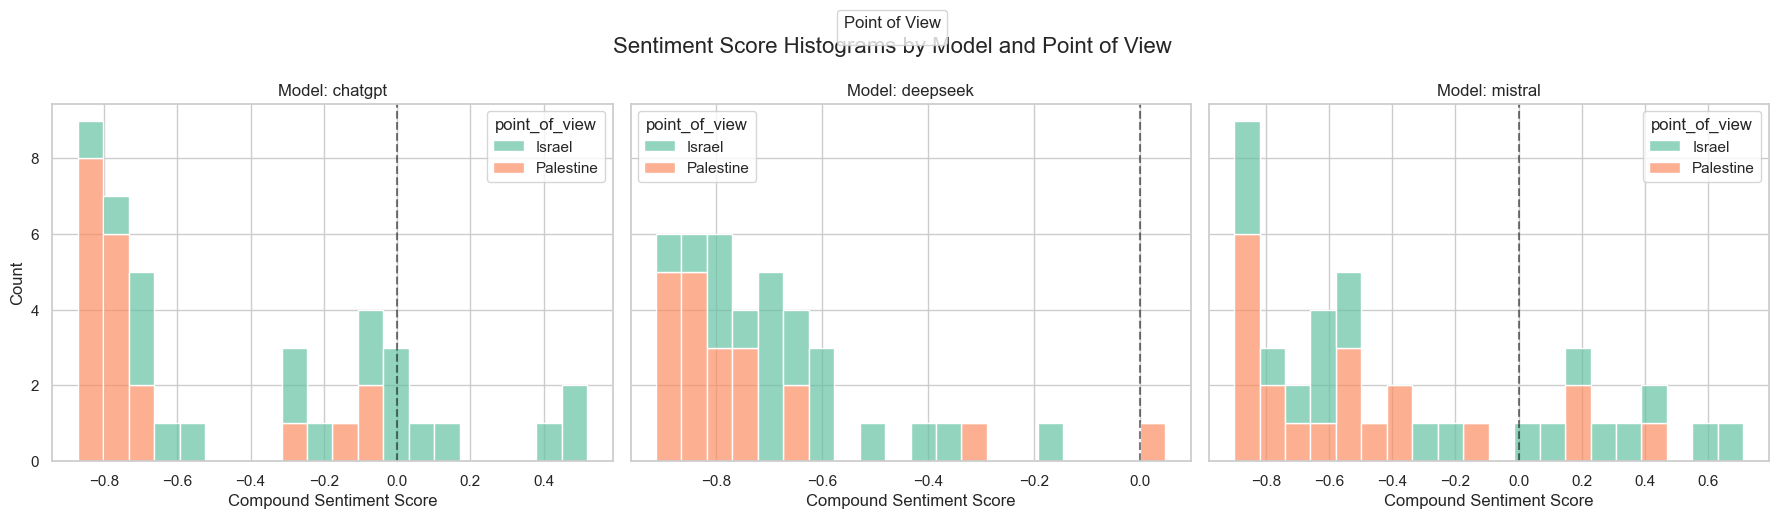


DENSITY HISTOGRAM - PDF


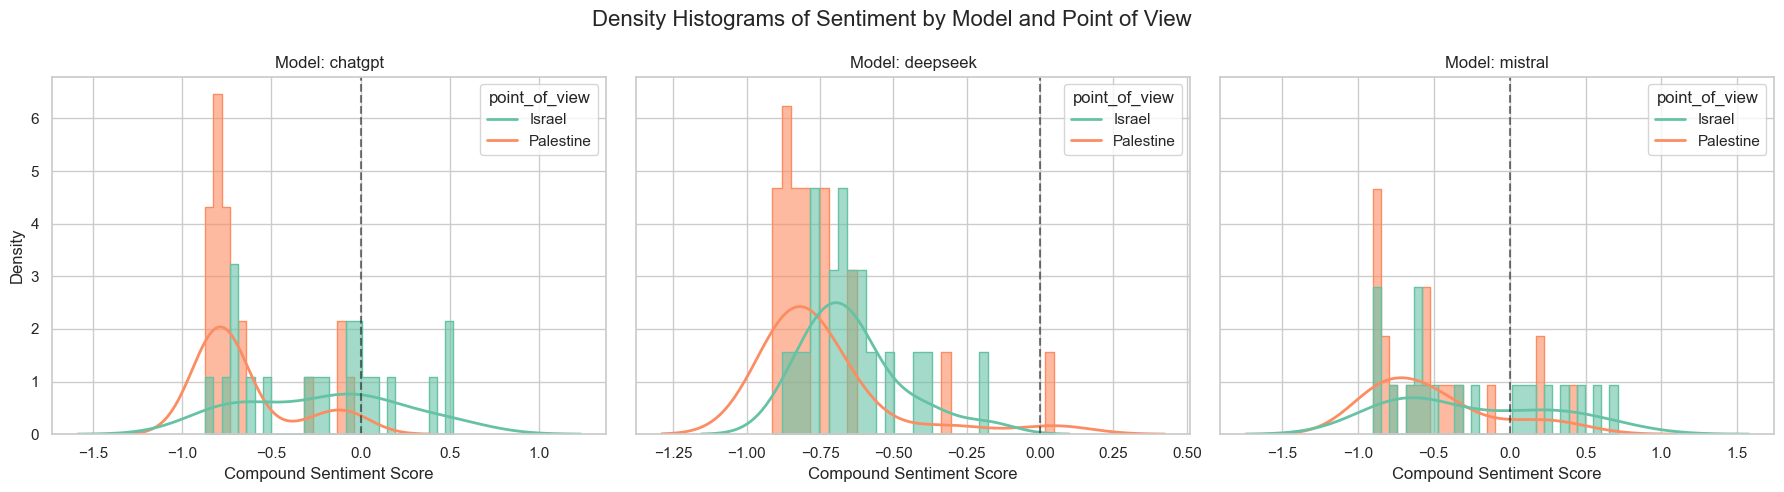


BERT-BASED MODEL COMPARISON

📊 Overall Sentiment Statistics:
                       overall_compound        overall_positive         \
                                   mean    std             mean    std   
model    point_of_view                                                   
chatgpt  Israel                  -0.214  0.433            0.130  0.169   
         Palestine               -0.655  0.272            0.025  0.038   
deepseek Israel                  -0.641  0.170            0.018  0.015   
         Palestine               -0.740  0.229            0.019  0.039   
mistral  Israel                  -0.245  0.525            0.162  0.223   
         Palestine               -0.512  0.402            0.060  0.117   

                       overall_negative        overall_neutral         
                                   mean    std            mean    std  
model    point_of_view                                                 
chatgpt  Israel                   0.344  0.299         

In [168]:
# Palestine Israel Conflict
screener = BERTHistoricalBiasScreener()
    
data = []
load_data("data/palestine_israel_conflict/chatgpt.txt", data)
load_data("data/palestine_israel_conflict/deepseek.txt", data)
load_data("data/palestine_israel_conflict/mistral.txt", data)

print(data[0])

# Analyze the responses
screener.batch_analyze(data)

# Get results
palestine_israel_results_df = screener.get_results_df()
print("\nResults DataFrame:")
print(palestine_israel_results_df[['model', 'point_of_view', 'overall_compound', 'overall_positive', 'overall_negative', 'overall_neutral']])

# Plot the datapoints as histograms
screener.plot_histogram()

# Plot density histogram
screener.plot_distribution()

# Compare models
screener.compare_models_overall()

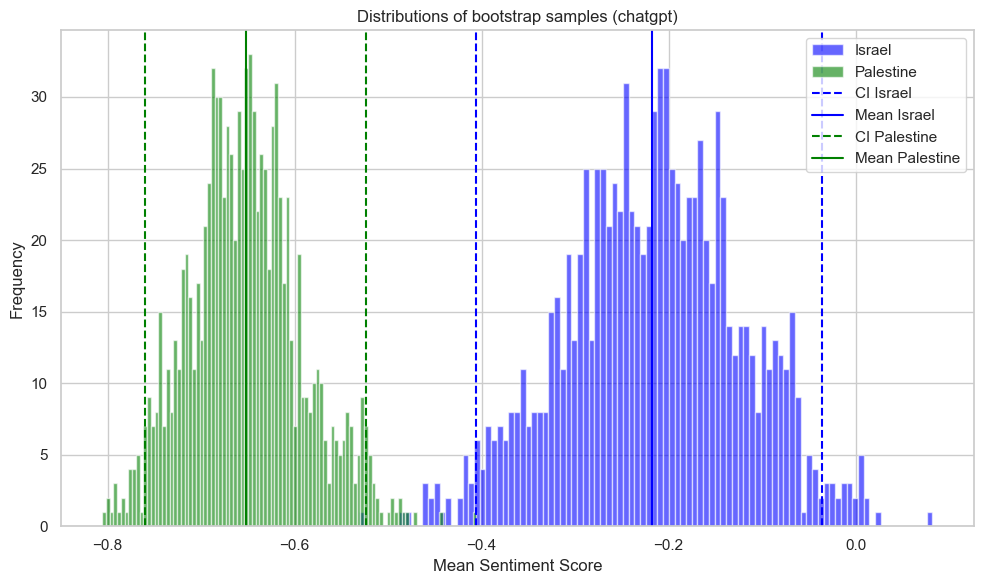

Confidence interval(Israel): [-0.41, -0.04]
Mean(Israel): -0.22

Confidence interval(Palestine): [-0.76, -0.52]
Mean(Palestine): -0.65


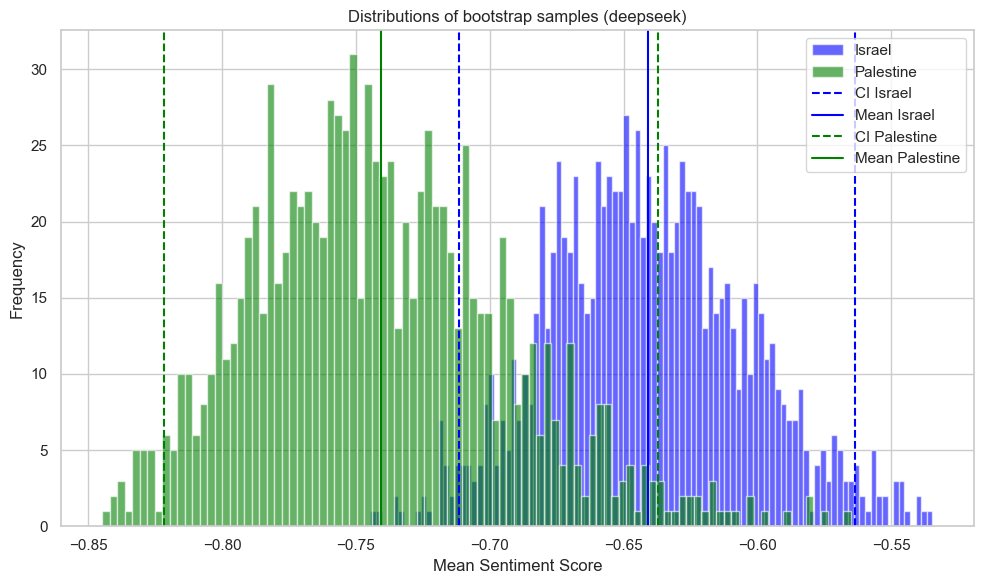

Confidence interval(Israel): [-0.71, -0.56]
Mean(Israel): -0.64

Confidence interval(Palestine): [-0.82, -0.64]
Mean(Palestine): -0.74


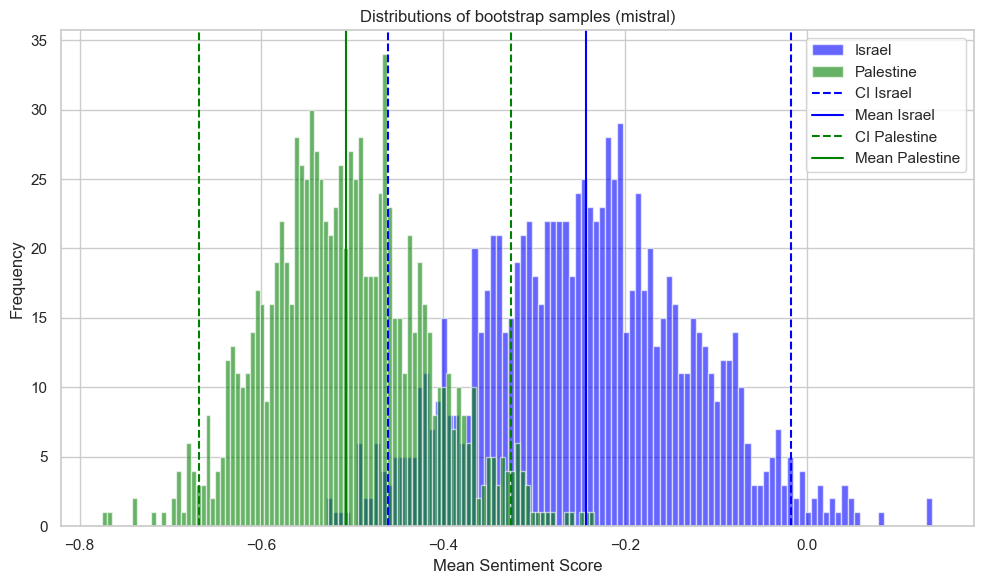

Confidence interval(Israel): [-0.46, -0.02]
Mean(Israel): -0.24

Confidence interval(Palestine): [-0.67, -0.33]
Mean(Palestine): -0.51


In [169]:
# Bootstrap 1000 samples of the calculated sentiment scores
chatgpt_israel = seperate_df(palestine_israel_results_df, "chatgpt", "Israel")
chatgpt_palestine = seperate_df(palestine_israel_results_df, "chatgpt", "Palestine")
deepseek_israel = seperate_df(palestine_israel_results_df, "deepseek", "Israel")
deepseek_palestine= seperate_df(palestine_israel_results_df, "deepseek", "Palestine")
mistral_israel = seperate_df(palestine_israel_results_df, "mistral", "Israel")
mistral_palestine = seperate_df(palestine_israel_results_df, "mistral", "Palestine")

chatgpt_israel_samples = bootstrap_samples(chatgpt_israel)
chatgpt_palestine_samples = bootstrap_samples(chatgpt_palestine)
deepseek_israel_samples = bootstrap_samples(deepseek_israel)
deepseek_palestine_samples = bootstrap_samples(deepseek_palestine)
mistral_israel_samples = bootstrap_samples(mistral_israel)
mistral_palestine_samples = bootstrap_samples(mistral_palestine)


plot_bootstrappings(chatgpt_israel_samples, chatgpt_palestine_samples, "chatgpt", "Israel", "Palestine")
plot_bootstrappings(deepseek_israel_samples, deepseek_palestine_samples, "deepseek", "Israel", "Palestine")
plot_bootstrappings(mistral_israel_samples, mistral_palestine_samples, "mistral", "Israel", "Palestine")

In [170]:
print("______Israel______")
print("ANOVA (Welch):")
welch_anova(chatgpt_israel_samples, deepseek_israel_samples, mistral_israel_samples)
print("Post-hoc (Games Howell):")
games_howell(chatgpt_israel_samples, deepseek_israel_samples, mistral_israel_samples)
print()

print("______Palestine______")
print("ANOVA (Welch):")
welch_anova(chatgpt_palestine_samples, deepseek_palestine_samples, mistral_palestine_samples)
print("Post-hoc (Games Howell):")
games_howell(chatgpt_palestine_samples, deepseek_palestine_samples, mistral_palestine_samples)


______Israel______
ANOVA (Welch):
Variance of Group 1: 0.0090
Variance of Group 2: 0.0014
Variance of Group 3: 0.0131

              sum_sq      df             F  PR(>F)
group     199.414668     2.0  12729.065888     0.0
Residual   23.475633  2997.0           NaN     NaN
Post-hoc (Games Howell):
    A   B   mean(A)   mean(B)      diff        se           T           df  \
0  g1  g2 -0.217255 -0.641058  0.423803  0.003222  131.547866  1297.524031   
1  g1  g3 -0.217255 -0.242694  0.025439  0.004703    5.408656  1931.105501   
2  g2  g3 -0.641058 -0.242694 -0.398363  0.003807 -104.627768  1206.345045   

           pval    hedges  
0  5.312417e-13  5.880791  
1  2.138516e-07  0.241792  
2  0.000000e+00 -4.677339  

______Palestine______
ANOVA (Welch):
Variance of Group 1: 0.0037
Variance of Group 2: 0.0022
Variance of Group 3: 0.0074

             sum_sq      df            F  PR(>F)
group     25.988680     2.0  2913.525215     0.0
Residual  13.366638  2997.0          NaN     NaN
Post-hoc

In [171]:
print("ChatGPT:")
t_test1 = t_test(chatgpt_israel_samples, chatgpt_palestine_samples)

print("DeepSeek:")
t_test1 = t_test(deepseek_israel_samples, deepseek_palestine_samples)

print("Mistral:")
t_test1 = t_test(mistral_israel_samples, mistral_palestine_samples)

ChatGPT:
Mean of Group 1       = -0.2173
Mean of Group 2       = -0.6524
Difference in Means   = 0.4351
Test Statistic        = 122.1021
P-value               = 0
Degrees of Freedom(v) = 1700.89
95% Confidence Interval = (0.4281, 0.4421)

DeepSeek:
Mean of Group 1       = -0.6411
Mean of Group 2       = -0.7407
Difference in Means   = 0.0996
Test Statistic        = 52.3904
P-value               = 0
Degrees of Freedom(v) = 1890.56
95% Confidence Interval = (0.0959, 0.1033)

Mistral:
Mean of Group 1       = -0.2427
Mean of Group 2       = -0.5075
Difference in Means   = 0.2648
Test Statistic        = 58.3893
P-value               = 0
Degrees of Freedom(v) = 1856.69
95% Confidence Interval = (0.2559, 0.2737)

